# Contextual Bandit with Continuous Actions

https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/python_cats.html

In [74]:
import json
import math
import random

import matplotlib.pyplot as plt
import vowpalwabbit

In [75]:
# VW minimizes loss/cost, therefore we will pass cost as -reward
USER_LIKED_TEMPERATURE = -1.0
USER_DISLIKED_TEMPERATURE = 0.0

In [76]:
def get_cost(context, temperature, min_value, max_value):
    range = float(max_value - min_value)
    match (context["room"], context["time_of_day"]):
        case ("Living Room", "morning"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Living Room", "afternoon"):
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Bedroom", "morning"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(22, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Bedroom", "afternoon"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case _:
            return USER_DISLIKED_TEMPERATURE

In [77]:
# This function modifies (context, temperature (i.e. action), cost, probability) to VW friendly json format
def to_vw_example_format(context, cats_label=None):
    example_dict = {}
    if cats_label is not None:
        chosen_temp, cost, pdf_value = cats_label
        example_dict["_label_ca"] = {
            "action": chosen_temp,
            "cost": cost,
            "pdf_value": pdf_value,
        }
    example_dict["c"] = {
        "room={}".format(context["room"]): 1,
        "time_of_day={}".format(context["time_of_day"]): 1,
    }
    return json.dumps(example_dict)

In [78]:
def predict_temperature(vw, context):
    vw_text_example = to_vw_example_format(context)
    return vw.predict(vw_text_example)

In [79]:
rooms = ["Living Room", "Bedroom"]
times_of_day = ["morning", "afternoon"]


def choose_room(rooms):
    return random.choice(rooms)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [90]:
def run_simulation(
    vw,
    num_iterations,
    rooms,
    times_of_day,
    cost_function,
    min_value,
    max_value,
    do_learn=True,
):
    reward_rate = []
    hits = 0
    cost_sum = 0.0

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a room
        room = choose_room(rooms)
        # 2. Choose time of day for a given room
        time_of_day = choose_time_of_day(times_of_day)
        # 3. Pass context to vw to get a temperature
        context = {"room": room, "time_of_day": time_of_day}
        temperature, pdf_value = predict_temperature(vw, context)

        # 4. Get cost of the action we chose
        cost = cost_function(context, temperature, min_value, max_value)
        if cost <= -0.75:  # count something as a hit only if it has a high reward
            hits += 1
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            txt_ex = to_vw_example_format(
                context, cats_label=(temperature, cost, pdf_value)
            )
            if i == 1:
                print(txt_ex)
            vw_format = vw.parse(txt_ex, vowpalwabbit.LabelType.CONTINUOUS)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        reward_rate.append(-1 * cost_sum / i)

    return reward_rate, hits

In [91]:
def plot_reward_rate(num_iterations, reward_rate, title):
    plt.show()
    plt.plot(range(1, num_iterations + 1), reward_rate)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("reward rate", fontsize=14)
    plt.title(title)
    plt.ylim([0, 1])

## With Learning

{"_label_ca": {"action": 0.0012017497792840004, "cost": 0.0, "pdf_value": 0.0062500000931322575}, "c": {"room=Bedroom": 1, "time_of_day=afternoon": 1}}


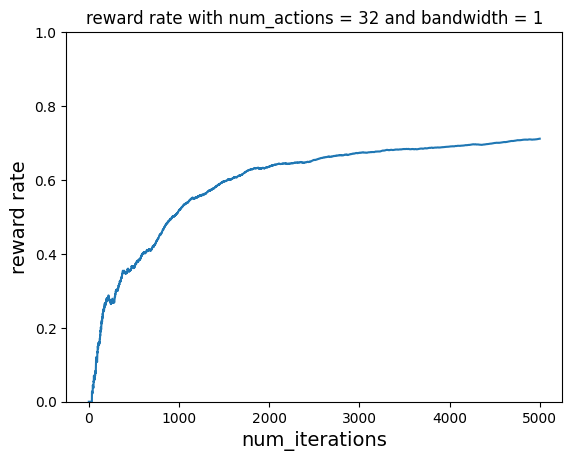

In [92]:
num_iterations = 5000

num_actions = 32
bandwidth = 1

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions} --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)
ctr, hits = run_simulation(
    vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=True
)
vw.finish()
plot_reward_rate(
    num_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

## Without Learning

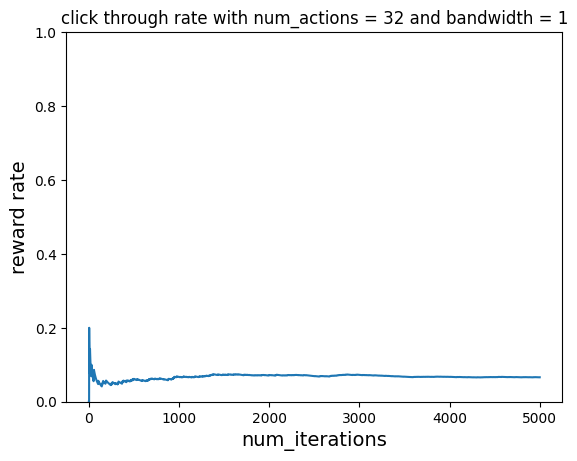

In [60]:
num_iterations = 5000

num_actions = 32
bandwidth = 1

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions} --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)
ctr, hits = run_simulation(
    vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=False
)
vw.finish()
plot_reward_rate(
    num_iterations, ctr, "click through rate with num_actions = 32 and bandwidth = 1"
)

## Parameter Sweep

In [61]:
def plot_reward_sweep(num_iterations, actions, bandwidths, data):
    plt.show()
    n_actions = len(actions)
    n_bandwidths = len(bandwidths)
    fig, axs = plt.subplots(n_actions, n_bandwidths)
    for i in range(0, len(actions)):
        for j in range(0, len(bandwidths)):
            if bandwidths[j] >= actions[i]:
                axs[i, j].set_title("NA")
                continue
            reward_rate, hits = data[str(actions[i])][str(bandwidths[j])]
            hits_percentage = (hits / (num_iterations)) * 100
            axs[i, j].plot(range(1, num_iterations + 1), reward_rate)
            axs[i, j].set_title(
                "hits {:.2f}% TR {:.2f}%".format(hits_percentage, reward_rate[-1] * 100)
            )
            axs[i, j].set_ylim([0, 1])

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            ax.set_xlabel("b: " + str(bandwidths[j % len(bandwidths)]), fontsize=14)
            ax.set_ylabel("k: " + str(actions[i % len(actions)]), fontsize=14)

    fig.text(0.5, 0.04, "num_iterations", ha="center", fontsize=14)
    fig.text(0.04, 0.5, "reward_rate", va="center", rotation="vertical", fontsize=14)
    fig.set_figheight(18)
    fig.set_figwidth(30)
    plt.suptitle("#examples {}".format(num_iterations))

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

## With Learning

Running simulation for: --cats 8 and --bandwidth 0
Running simulation for: --cats 8 and --bandwidth 1
Running simulation for: --cats 8 and --bandwidth 2
Running simulation for: --cats 8 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 0
Running simulation for: --cats 32 and --bandwidth 1
Running simulation for: --cats 32 and --bandwidth 2
Running simulation for: --cats 32 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 25
Running simulation for: --cats 64 and --bandwidth 0
Running simulation for: --cats 64 and --bandwidth 1
Running simulation for: --cats 64 and --bandwidth 2
Running simulation for: --cats 64 and --bandwidth 3
Running simulation for: --cats 64 and --bandwidth 25
Running simulation for: --cats 128 and --bandwidth 0
Running simulation for: --cats 128 and --bandwidth 1
Running simulation for: --cats 128 and --bandwidth 2
Running simulation for: --cats 128 and --bandwidth 3
Running simulation for: --cats 128 and --bandwidth 25
Running 

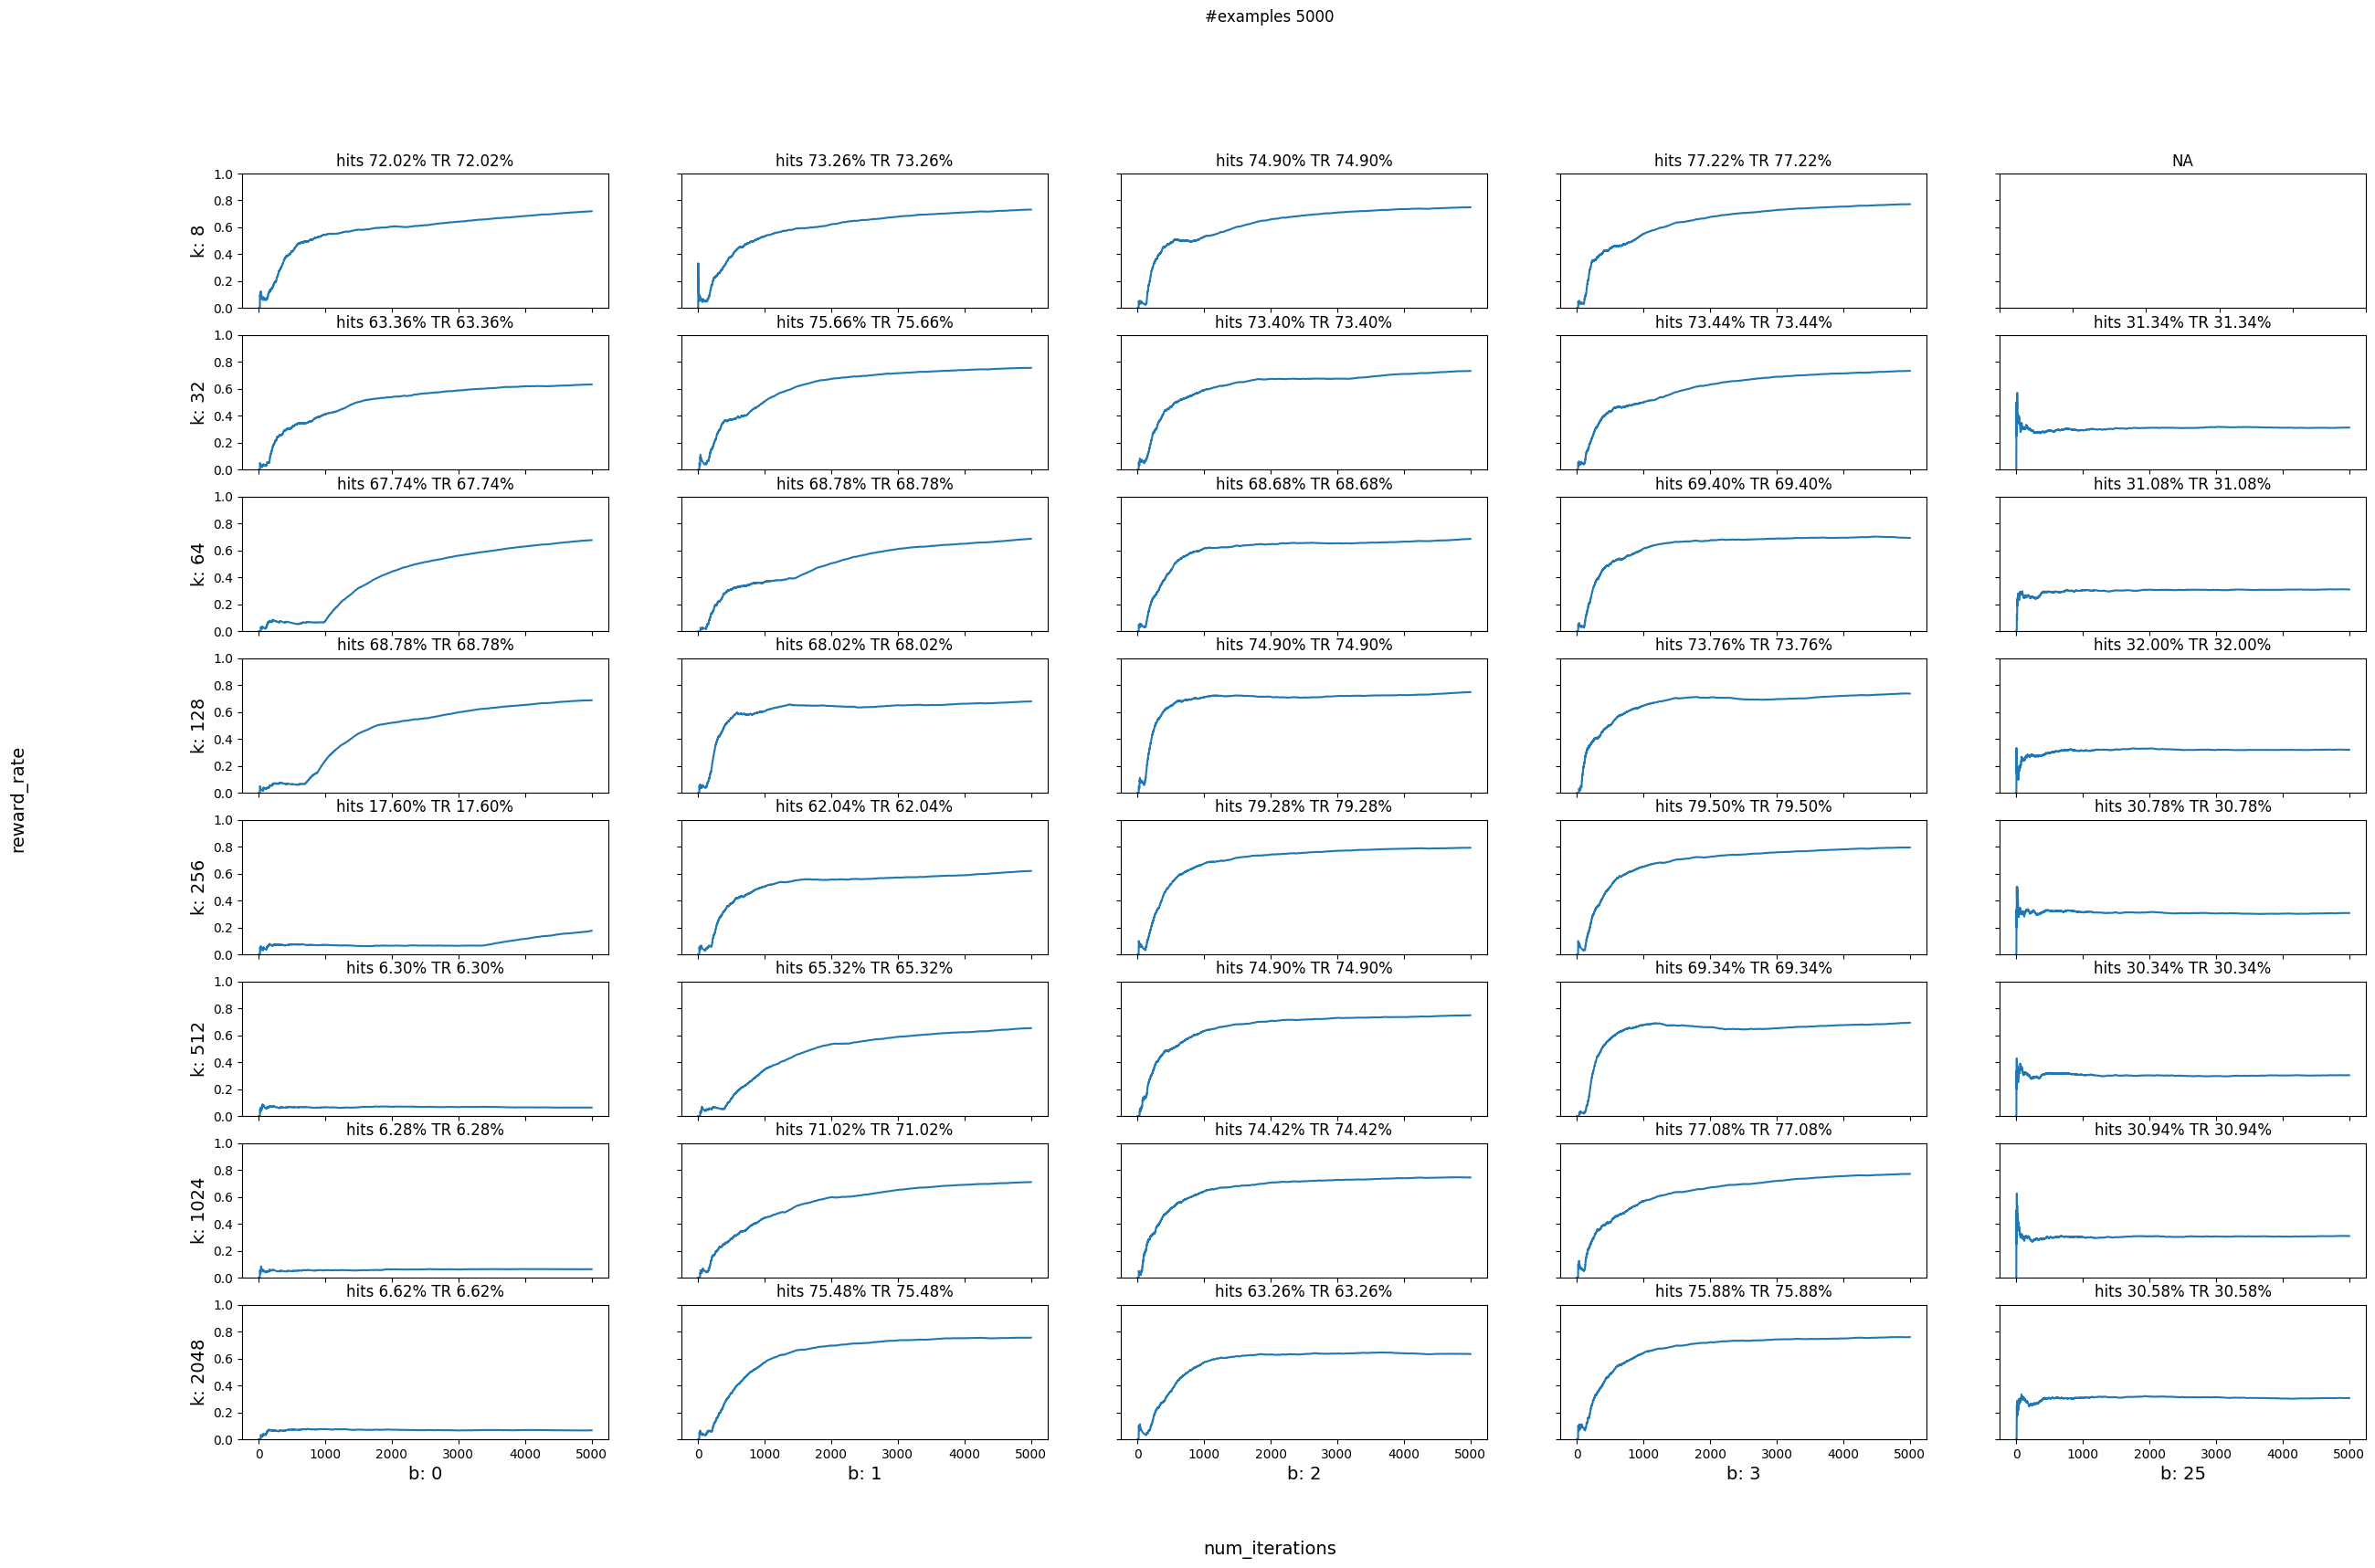

In [63]:
# do parameter sweeping
data = {}
num_actions = [8, 32, 64, 128, 256, 512, 1024, 2048]
bandwidths = [0, 1, 2, 3, 25]

num_iterations = 5000

for actions in num_actions:
    for bd in bandwidths:
        if str(actions) not in data:
            data[str(actions)] = {}
        if bd >= actions:
            continue
        print(f"Running simulation for: --cats {actions} and --bandwidth {bd}")
        vw = vowpalwabbit.Workspace(
            f"--cats {actions}  --bandwidth {bd} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
        )
        rr, hits = run_simulation(
            vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=True
        )
        vw.finish()

        data[str(actions)][str(bd)] = (rr, hits)

plot_reward_sweep(num_iterations, num_actions, bandwidths, data)

## Without Learning

Running simulation for: --cats 8 and --bandwidth 0
Running simulation for: --cats 8 and --bandwidth 1
Running simulation for: --cats 8 and --bandwidth 2
Running simulation for: --cats 8 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 0
Running simulation for: --cats 32 and --bandwidth 1
Running simulation for: --cats 32 and --bandwidth 2
Running simulation for: --cats 32 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 25
Running simulation for: --cats 64 and --bandwidth 0
Running simulation for: --cats 64 and --bandwidth 1
Running simulation for: --cats 64 and --bandwidth 2
Running simulation for: --cats 64 and --bandwidth 3
Running simulation for: --cats 64 and --bandwidth 25
Running simulation for: --cats 128 and --bandwidth 0
Running simulation for: --cats 128 and --bandwidth 1
Running simulation for: --cats 128 and --bandwidth 2
Running simulation for: --cats 128 and --bandwidth 3
Running simulation for: --cats 128 and --bandwidth 25
Running 

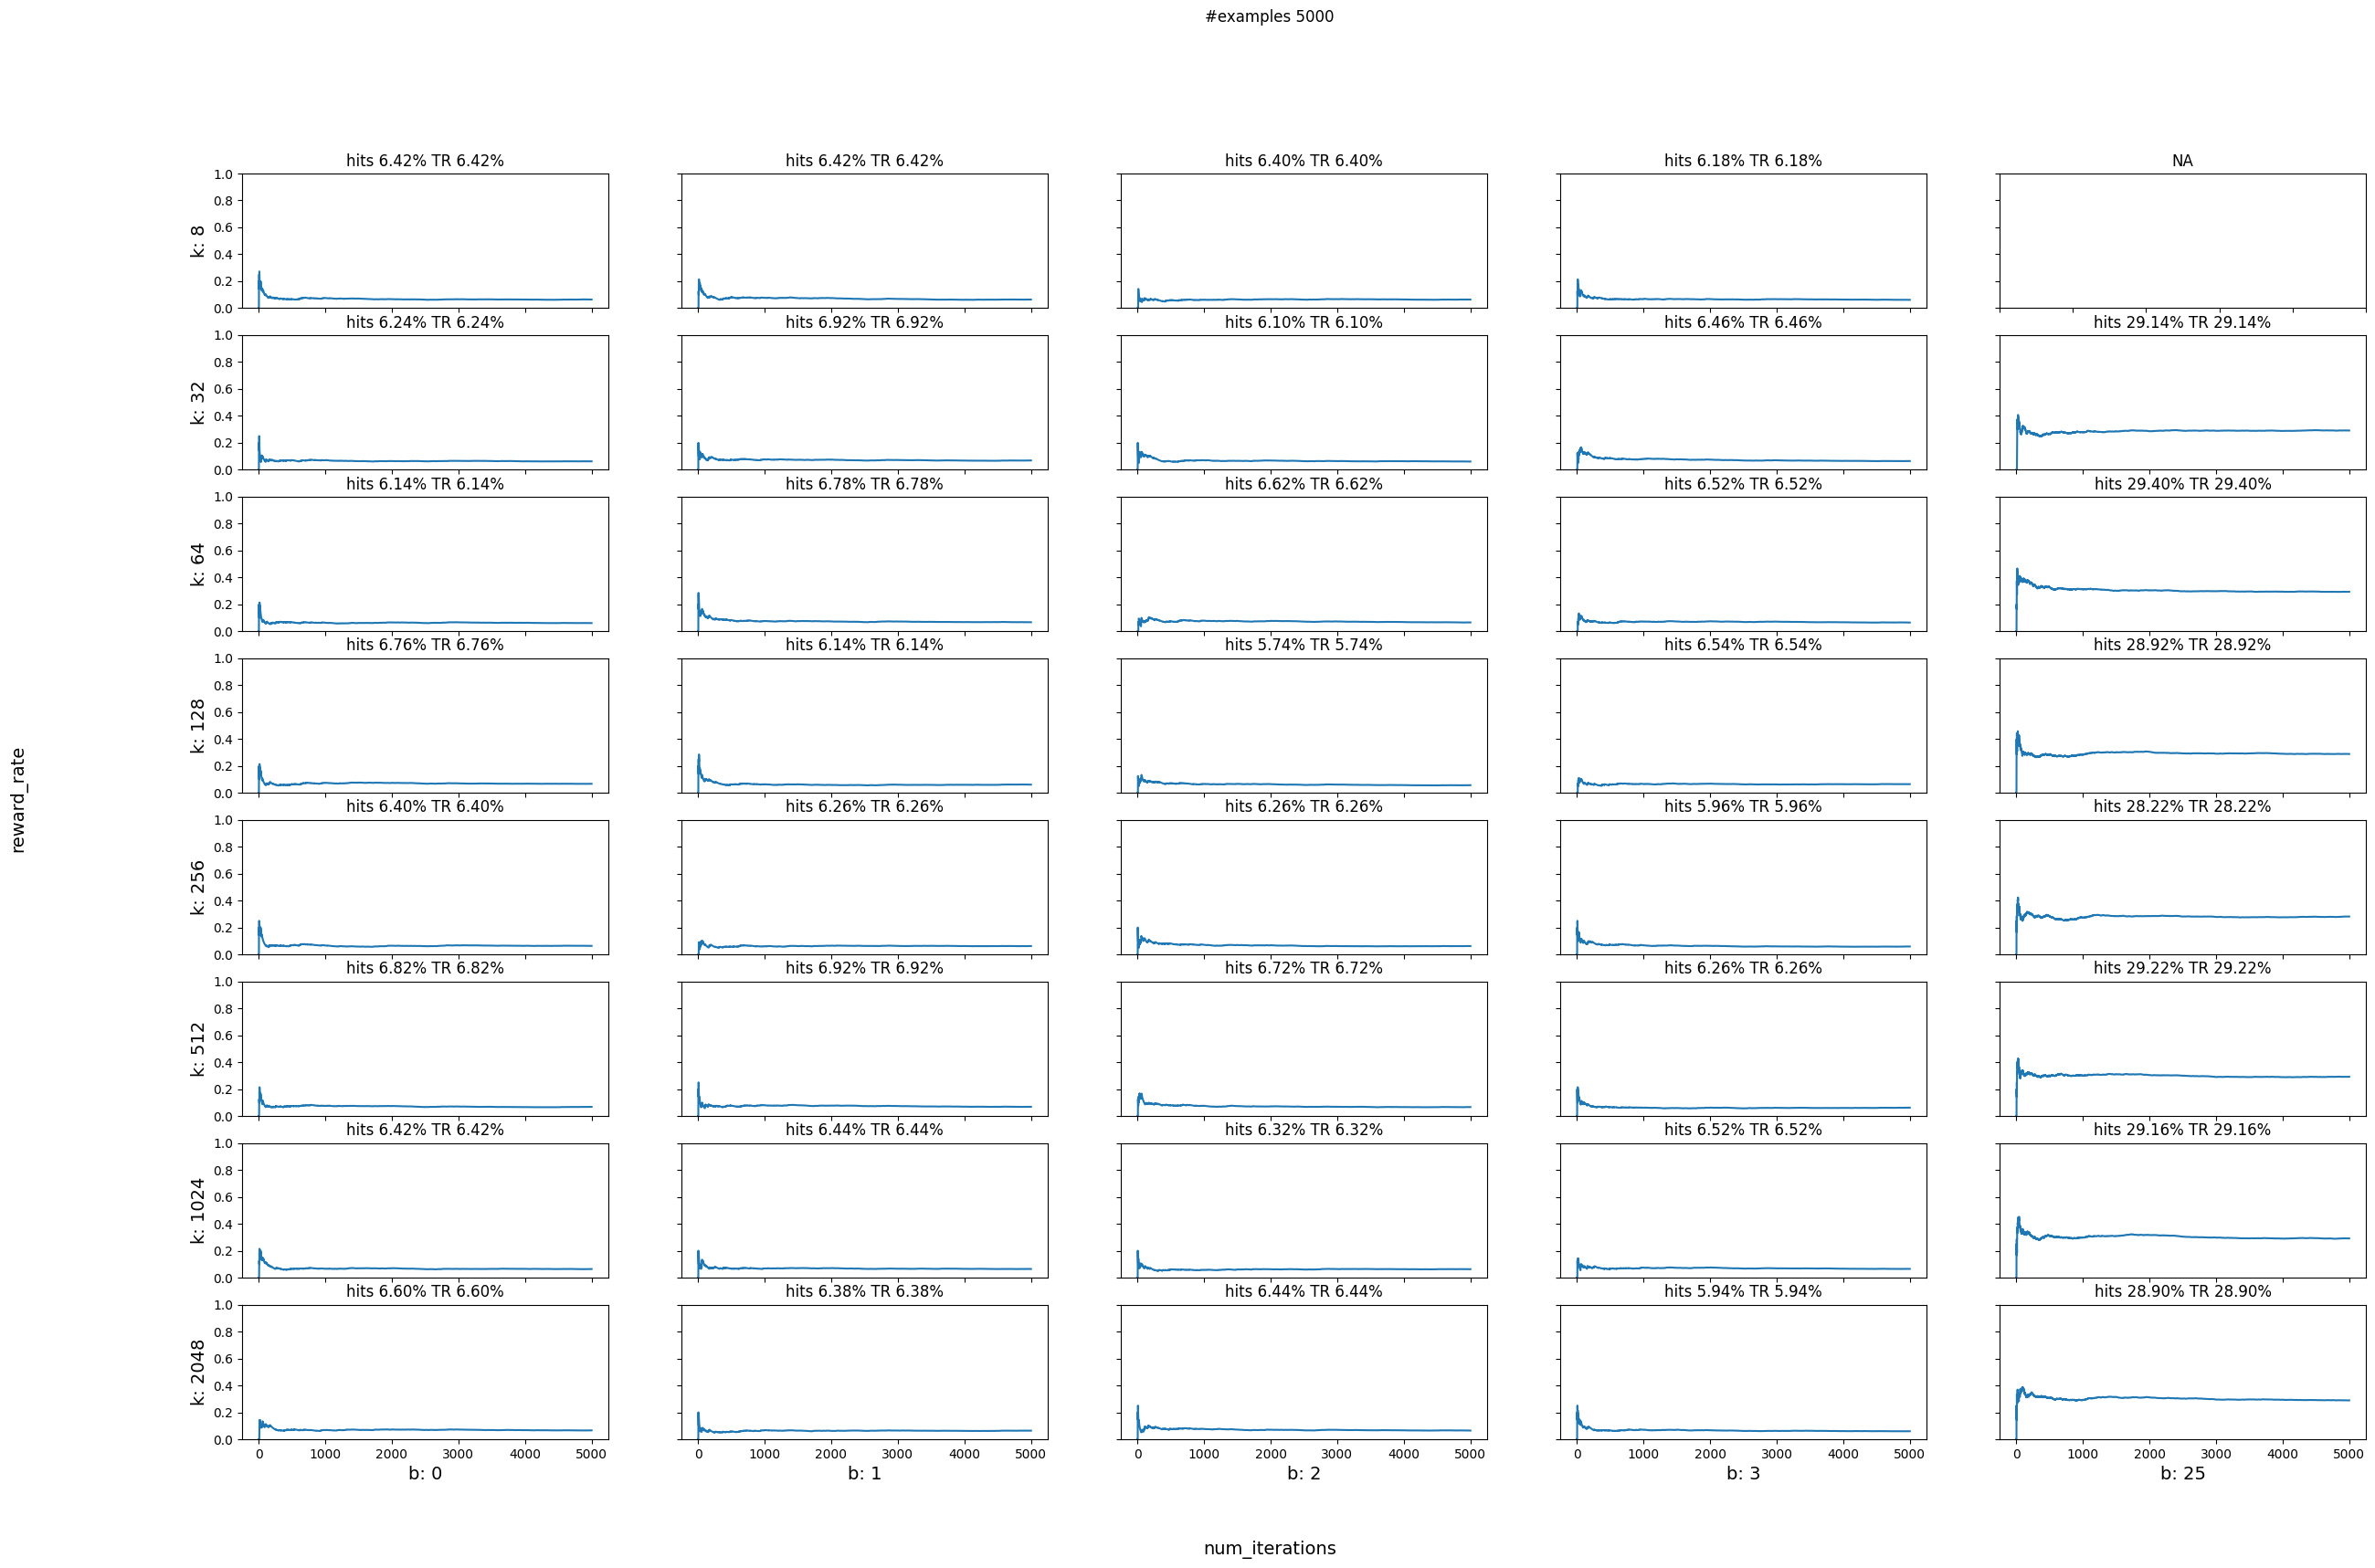

In [64]:
# do parameter sweeping
data = {}
num_actions = [8, 32, 64, 128, 256, 512, 1024, 2048]
bandwidths = [0, 1, 2, 3, 25]

num_iterations = 5000

for actions in num_actions:
    for bd in bandwidths:
        if str(actions) not in data:
            data[str(actions)] = {}
        if bd >= actions:
            continue
        print(f"Running simulation for: --cats {actions} and --bandwidth {bd}")
        vw = vowpalwabbit.Workspace(
            f"--cats {actions} --bandwidth {bd} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
        )
        rr, hits = run_simulation(
            vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=False
        )
        vw.finish()
        data[str(actions)][str(bd)] = (rr, hits)

plot_reward_sweep(num_iterations, num_actions, bandwidths, data)

# Scenario 2

In [66]:
def get_cost_1(context, temperature, min_value, max_value):
    range = float(max_value - min_value)
    match (context["room"], context["time_of_day"]):
        case ("Living Room", "morning"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Living Room", "afternoon"):
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Bedroom", "morning"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case ("Bedroom", "afternoon"):
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        case _:
            return USER_DISLIKED_TEMPERATURE

In [67]:
def run_simulation_multiple_cost_functions(
    vw,
    num_iterations,
    rooms,
    times_of_day,
    cost_functions,
    min_value,
    max_value,
    do_learn=True,
):
    reward_rate = []
    hits = 0
    cost_sum = 0.0

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. In each simulation choose a room
            room = choose_room(rooms)
            # 2. Choose time of day for a given room
            time_of_day = choose_time_of_day(times_of_day)
            # 3. Pass context to vw to get a temperature
            context = {"room": room, "time_of_day": time_of_day}
            temperature, pdf_value = predict_temperature(vw, context)

            # 4. Get cost of the action we chose
            cost = cost_function(context, temperature, min_value, max_value)
            if cost <= -0.75:  # count something as a hit only if it has a high reward
                hits += 1
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                txt_ex = to_vw_example_format(
                    context, cats_label=(temperature, cost, pdf_value)
                )
                vw_format = vw.parse(txt_ex, vowpalwabbit.LabelType.CONTINUOUS)
                # 6. Learn
                vw.learn(vw_format)
                # 7. Let VW know you're done with these objects
                vw.finish_example(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            reward_rate.append(-1 * cost_sum / i)

        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return reward_rate, hits

## With Learning

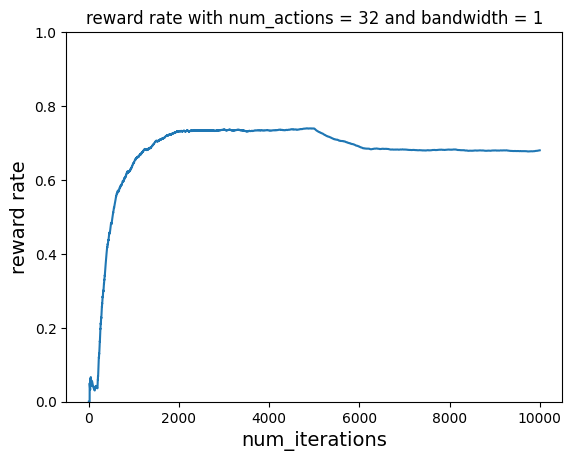

In [68]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
num_actions = 128
bandwidth = 2

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions}  --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, hits = run_simulation_multiple_cost_functions(
    vw,
    num_iterations_per_cost_func,
    rooms,
    times_of_day,
    cost_functions,
    0,
    32,
    do_learn=True,
)
vw.finish()
plot_reward_rate(
    total_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

## Without Learning

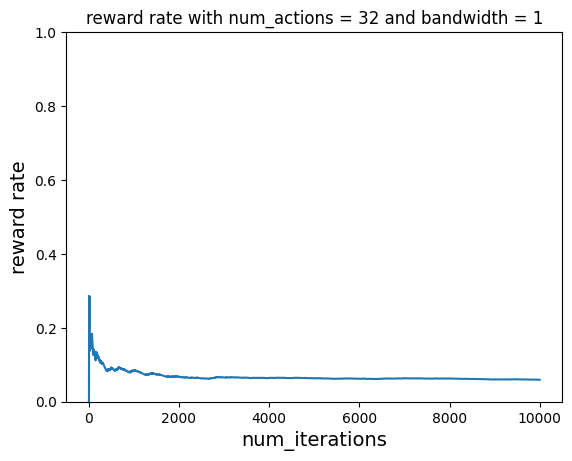

In [70]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
num_actions = 128
bandwidth = 2

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions} --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, hits = run_simulation_multiple_cost_functions(
    vw,
    num_iterations_per_cost_func,
    rooms,
    times_of_day,
    cost_functions,
    0,
    32,
    do_learn=False,
)
vw.finish()
plot_reward_rate(
    total_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

In [96]:
list(vowpalwabbit.LabelType)

[<LabelType.SIMPLE: 1>,
 <LabelType.MULTICLASS: 2>,
 <LabelType.COST_SENSITIVE: 3>,
 <LabelType.CONTEXTUAL_BANDIT: 4>,
 <LabelType.CONDITIONAL_CONTEXTUAL_BANDIT: 6>,
 <LabelType.SLATES: 7>,
 <LabelType.CONTINUOUS: 8>,
 <LabelType.CONTEXTUAL_BANDIT_EVAL: 9>,
 <LabelType.MULTILABEL: 10>]